# Preprocessing

In [1]:
%%bash
rm -rf /kaggle/working/*

In [2]:
%%bash
pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 82.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1


In [3]:
!pip install --upgrade pip
!pip install torch==2.2.2+cu118 torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install flash-attn --no-build-isolation
!pip install accelerate transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.2/819.2 MB 32.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 49.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 MB 60.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 106.5 MB/s eta 0:00:0000:0100:01
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 65.6 MB/s eta 0:00:00
     ━━

In [2]:
!git clone https://github.com/princeton-nlp/SimPO.git
%cd SimPO
!pip install -r requirements.txt

Cloning into 'SimPO'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 330 (delta 125), reused 103 (delta 103), pack-reused 169 (from 1)
Receiving objects: 100% (330/330), 2.99 MiB | 23.94 MiB/s, done.
Resolving deltas: 100% (176/176), done.
/kaggle/working/SimPO
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
!pip install ace_tools_open

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.3 MB/s eta 0:00:0000:010:01


In [4]:
from datasets import load_dataset
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import ace_tools_open as tools

In [5]:
pos_paths = [
    "/kaggle/input/simpo-dataset/Civil Code (part one).xlsx",
    "/kaggle/input/simpo-dataset/Civil Code (part two).xlsx"
]
neg_path = "/kaggle/input/simpo-dataset/Negative class (2).xlsx"

In [6]:
df_pos1 = pd.read_excel(pos_paths[0])
df_pos2 = pd.read_excel(pos_paths[1])
df_neg = pd.read_excel(neg_path)

In [7]:
df_pos = pd.concat([df_pos1, df_pos2], ignore_index=True)
df_pos['label'] = 1
df_neg['label'] = 0

In [8]:
df = pd.concat([df_pos, df_neg], ignore_index=True).sample(frac=1, random_state=42)

In [9]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [10]:
train_df.to_csv("train.csv", index=False)
val_df.to_csv("validation.csv", index=False)
test_df.to_csv("test.csv", index=False)

tools.display_dataframe_to_user("Aggregated data with labels", df.head())

Aggregated data with labels


In [11]:
train_df.head()

,Text,label
902,Решение собрания может быть признано судом нед...,1
1267,Если каждая из сторон по договору несет обязан...,1
2856,По договору условного депонирования депонент ...,1
845,"За исключением случаев, предусмотренных пункто...",1
977,"Если законом не установлено иное, течение срок...",1


# Training

In [12]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, BitsAndBytesConfig, T5ForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch
from peft import LoraConfig, get_peft_model

2025-04-22 04:42:06.503729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745296926.695654      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745296926.748393      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
!pip install peft datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.

In [14]:
data_files = {"train": "train.csv", "validation": "validation.csv"}
raw_datasets = load_dataset("csv", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [15]:
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bnb_config = BitsAndBytesConfig(load_in_8bit=True)


base_model = T5ForConditionalGeneration.from_pretrained(
    "t5-small",
    device_map={"": "cpu"},
    torch_dtype=torch.float16
)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [16]:
lora_config = LoraConfig(
    task_type="SEQ_2_SEQ_LM", 
    r=8, 
    lora_alpha=16,
    target_modules=["q","v"], 
    lora_dropout=0.05
)

model = get_peft_model(base_model, lora_config)

model = model.to("cuda")

In [17]:
def preprocess_fn(examples):
    inputs = ["Classify text as legal or non-legal: " + txt for txt in examples["Text"]]
    targets = ["legal" if lab == 1 else "non-legal" for lab in examples["label"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=4, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_fn, batched=True, remove_columns=["Text", "label"])

Map:   0%|          | 0/2615 [00:00<?, ? examples/s]

Map:   0%|          | 0/327 [00:00<?, ? examples/s]

In [18]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [19]:
training_args = Seq2SeqTrainingArguments(
    output_dir="lora_t5_classifier",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    logging_steps=50,
    logging_first_step=True,
    do_train=True,
    do_eval=True,
    eval_steps=100,
    save_steps=100,
    save_strategy="epoch", 
    save_total_limit=2,
    learning_rate=5e-5,
    predict_with_generate=True,
    report_to=[]
)

In [20]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

/tmp/ipykernel_31/3607913767.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [21]:
import time

start_time = time.time()
trainer.train()
end_time = time.time()
print(f"\n Время обучения: {(end_time - start_time)/60:.2f} минут")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
1,17.609400
50,16.982600
100,14.574900
150,10.994100
200,7.307500
250,4.382500
300,2.636100
350,1.344800
400,0.789600
450,0.528300



 Время обучения: 9.58 минут


In [58]:
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [59]:
download_file('/kaggle/working/SimPO/__MACOSX', 'out')

Unable to run zip command!



In [ ]:
model.save_pretrained("lora_t5_classifier")

# Evaluation

In [ ]:
!pip install --upgrade transformers bitsandbytes peft datasets --quiet

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
from peft import PeftConfig, PeftModel
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration
from peft import PeftModel

In [23]:
df_test = pd.read_csv("/kaggle/working/SimPO/test.csv")

In [24]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
base_model = T5ForConditionalGeneration.from_pretrained(
    "t5-small",
    device_map={"": "cpu"},
    torch_dtype=torch.float16
)

In [25]:
os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"
os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [26]:
adapter_dir = "/kaggle/working/SimPO/lora_t5_classifier/checkpoint-3270"
config = PeftConfig.from_pretrained(adapter_dir, local_files_only=True)

In [27]:
model = PeftModel.from_pretrained(
    base_model,
    adapter_dir,
    config=config,
    is_trainable=False,
    local_files_only=True
)
model.to("cpu")
model.eval()

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 512)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 512)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=512, out_features=512, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=512, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=512, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
              

In [28]:
texts = ["Classify text as legal or non-legal: " + t for t in df_test["Text"]]
enc = tokenizer(
    texts,
    truncation=True,
    padding="max_length",
    max_length=512,
    return_tensors="pt"
)

In [29]:
if hasattr(model, "base_model"):
    lm = model.base_model       
else:
    lm = model.get_base_model()  

lm.to(model.device).eval()

LoraModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): lora.Linear(
                  (base_layer): Linear(in_features=512, out_features=512, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=512, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8, out_features=512, bias=False)
                  )
                  (lora_embedding_A): ParameterDict()
                  (lora_embedding_B): ParameterDict()
                  (lora_magnitude_vector)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lm.to(device)
enc = enc.to(device)
with torch.no_grad():
    outs = lm.generate(
        input_ids=enc["input_ids"],
        attention_mask=enc["attention_mask"],
        max_new_tokens=2,   
        num_beams=1,        
        do_sample=False,
        use_cache=True
    )

In [31]:
device

device(type='cuda')

In [32]:
batch_size = 32
preds = []
for i in range(0, len(texts), batch_size):
    chunk = tokenizer(
        texts[i:i+batch_size],
        padding=True, truncation=True, max_length=512, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        out = lm.generate(**chunk, max_new_tokens=2, num_beams=1)
    preds += tokenizer.batch_decode(out, skip_special_tokens=True)

In [33]:
with torch.no_grad():
    outs = lm.generate(
        input_ids=enc["input_ids"].to(lm.device),
        attention_mask=enc["attention_mask"].to(lm.device),
        max_length=4
    )
preds = tokenizer.batch_decode(outs, skip_special_tokens=True)

In [34]:
true = ["legal" if lab == 1 else "non-legal" for lab in df_test["label"]]
print("Classification Report:\n",
      classification_report(true, preds, target_names=["legal","non-legal"]))

cm = confusion_matrix(true, preds, labels=["legal","non-legal"])
df_cm = pd.DataFrame(cm,
                     index=["true_legal","true_non-legal"],
                     columns=["pred_legal","pred_non-legal"])
tools.display_dataframe_to_user("Confusion Matrix", df_cm)

Classification Report:
               precision    recall  f1-score   support

       legal       0.98      1.00      0.99       322
   non-legal       0.00      0.00      0.00         5

    accuracy                           0.98       327
   macro avg       0.49      0.50      0.50       327
weighted avg       0.97      0.98      0.98       327

Confusion Matrix


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
import matplotlib.pyplot as plt

steps = [
    1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500,
    550, 600, 650, 700, 750, 800, 850, 900, 950, 1000,
    1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450,
    1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950,
    2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450,
    2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950,
    3000, 3050, 3100, 3150, 3200, 3250
]
losses = [
    17.6094, 16.9826, 14.5749, 10.9941, 7.3075, 4.3825, 2.6361, 1.3448, 0.7896, 0.5283, 0.4013,
    0.2646, 0.2815, 0.2060, 0.2111, 0.1411, 0.1085, 0.1322, 0.0943, 0.1211, 0.1237,
    0.0983, 0.0782, 0.0472, 0.0985, 0.0886, 0.0442, 0.0805, 0.0531, 0.0592,
    0.0890, 0.0606, 0.0365, 0.0570, 0.0813, 0.0572, 0.0240, 0.0677, 0.0493, 0.0466,
    0.0357, 0.0438, 0.0471, 0.0549, 0.0537, 0.0612, 0.0491, 0.0554, 0.0197, 0.0443,
    0.0482, 0.0225, 0.0580, 0.0615, 0.0319, 0.0631, 0.0521, 0.0590, 0.0393, 0.0281,
    0.0243, 0.0284, 0.0528, 0.0410, 0.0408, 0.0393
]

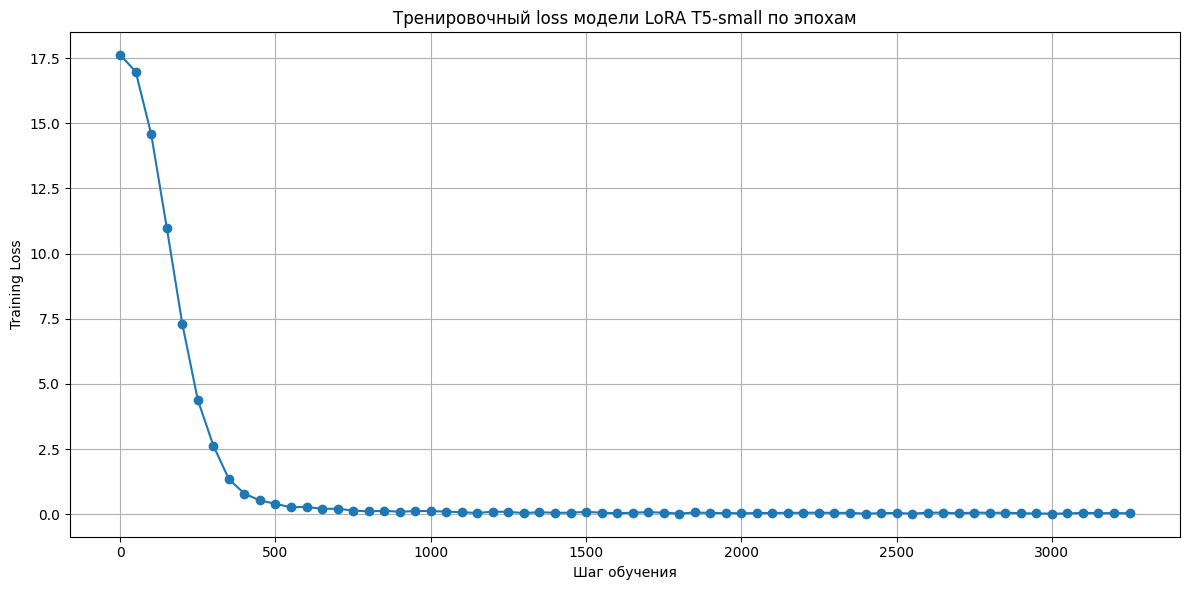

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(steps, losses, marker='o')
plt.title("Тренировочный loss модели LoRA T5-small по эпохам")
plt.xlabel("Шаг обучения")
plt.ylabel("Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()